In [1]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2024-05-09 19:25:42--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2024-05-09 19:25:43--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04df469ce26cc3d81f5a41d3d5.dl.dropboxusercontent.com/cd/0/inline/CSlWGXXoDT1C6Mxo9IKob-XqeCs7KwfSQ1VUf-NazjkJwO8F7HVwvSSuM-_UvDtOZ8gd5tyWudteHik_gksIZCOmHSpmnwk8GAqmRBFrELDV27xt2p_91Mm8OdOSoEQfTeDuRZUr34Ne5gbyxAoHHt-U/file# [following]
--2024-05-09 19:25:43--  https://uc04df469ce26cc3d81f5a41d3d5.dl.dropboxusercontent.com/cd/0/inline/CSlWGXXoDT1C6Mxo9IKob-XqeCs7KwfSQ1VUf-NazjkJwO8F7HVwvSSuM-_UvDtOZ8gd5tyWudteHik_gksIZCOmHSpmnwk8GAqmRBF

In [2]:
!unzip -q "/content/archive.zip"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
tf.random.set_seed(4)

In [5]:
train_path = Path("/content/train")
test_path = Path("/content/test")

In [6]:
train_img_paths = list(train_path.glob("*/*"))
train_img_paths = np.array(train_img_paths)

train_img_paths[:10]

array([PosixPath('/content/train/happy/Training_73694624.jpg'),
       PosixPath('/content/train/happy/Training_59763306.jpg'),
       PosixPath('/content/train/happy/Training_45016309.jpg'),
       PosixPath('/content/train/happy/Training_59945252.jpg'),
       PosixPath('/content/train/happy/Training_36857446.jpg'),
       PosixPath('/content/train/happy/Training_2093738.jpg'),
       PosixPath('/content/train/happy/Training_43851987.jpg'),
       PosixPath('/content/train/happy/Training_1902224.jpg'),
       PosixPath('/content/train/happy/Training_25941329.jpg'),
       PosixPath('/content/train/happy/Training_28006171.jpg')],
      dtype=object)

In [7]:
def get_label(image_path):
  return Path(image_path).parts[-2]

train_img_paths = list(train_path.glob("*/*"))
train_img_labels = np.array(list(map(lambda x: get_label(x), train_img_paths)))

train_img_labels[:10]

array(['happy', 'happy', 'happy', 'happy', 'happy', 'happy', 'happy',
       'happy', 'happy', 'happy'], dtype='<U8')

In [8]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_img_labels = Le.fit_transform(train_img_labels)

train_img_labels[:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [9]:
train_img_labels = tf.keras.utils.to_categorical(train_img_labels)

train_img_labels[:10]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [10]:
from sklearn.model_selection import train_test_split

Train_paths, Val_paths, Train_labels, Val_Labels = train_test_split(train_img_paths, train_img_labels, test_size = 0.25)

In [11]:
classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max()/classTotals

class_weight = {e:weight for e, weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7781075, 1: 16.696594, 2: 1.7699376, 3: 1.0, 4: 1.4540308, 5: 1.4811865, 6: 2.261216}


In [12]:
def load(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  return image, label

In [13]:
IMG_SIZE = 96
BATCH_SIZE = 32

resize= tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)])

data_aug = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, -0.05))
])

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths, labels, train = True):
  img_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  img_dt = tf.data.Dataset.from_tensor_slices(img_paths)
  label_dt = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((img_dt, label_dt))

  dataset = dataset.map(lambda image, label : load(image, label))
  dataset = dataset.map(lambda image, label : (resize(image), label), num_parallel_calls=AUTOTUNE)
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(BATCH_SIZE)

  if train:
    dataset = dataset.map(lambda image, label: (data_aug(image), label), num_parallel_calls=AUTOTUNE)

  dataset = dataset.repeat(10)
  return dataset

In [24]:
print("Val_paths:", Val_paths)

Val_paths: [PosixPath('/content/train/happy/Training_58459668.jpg'), PosixPath('/content/train/sad/Training_84896042.jpg'), PosixPath('/content/train/happy/Training_37412850.jpg'), PosixPath('/content/train/fear/Training_73744376.jpg'), PosixPath('/content/train/sad/Training_42398856.jpg'), PosixPath('/content/train/happy/Training_66403051.jpg'), PosixPath('/content/train/happy/Training_5292602.jpg'), PosixPath('/content/train/happy/Training_61893124.jpg'), PosixPath('/content/train/happy/Training_64671715.jpg'), PosixPath('/content/train/angry/Training_73148291.jpg'), PosixPath('/content/train/happy/Training_89060575.jpg'), PosixPath('/content/train/happy/Training_74023728.jpg'), PosixPath('/content/train/fear/Training_45930535.jpg'), PosixPath('/content/train/sad/Training_33054659.jpg'), PosixPath('/content/train/angry/Training_38018954.jpg'), PosixPath('/content/train/happy/Training_4746688.jpg'), PosixPath('/content/train/sad/Training_75848425.jpg'), PosixPath('/content/train/angry

In [25]:
print("Val_labels:", Val_Labels)

Val_labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [26]:
def path_to_tensor(path):
  """Converts a pathlib.PosixPath object to a string tensor."""
  return tf.convert_to_tensor(str(path))

train_img_paths = list(train_path.glob("*/*"))
train_img_paths_tensor = tf.convert_to_tensor(list(map(path_to_tensor, train_img_paths)))

train_img_labels = list(train_path.glob("*/*"))
train_img_labels_tensor = tf.convert_to_tensor(list(map(path_to_tensor, train_img_labels)))

In [27]:
%time train_dataset = get_dataset(train_img_paths_tensor, Train_labels)

CPU times: user 209 ms, sys: 4.34 ms, total: 213 ms
Wall time: 212 ms


In [28]:
image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


happy


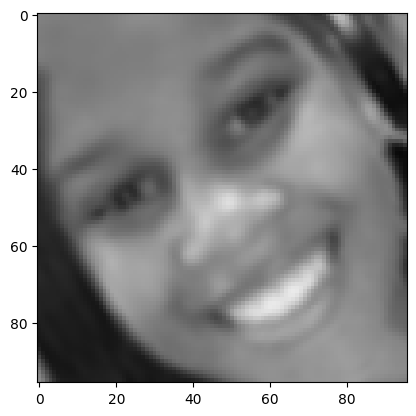

In [29]:
print(Le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96,96,3))

In [ ]:
%time val_dataset = get_dataset(train_img_labels_tensor, Val_Labels, train = False)

CPU times: user 41.5 ms, sys: 0 ns, total: 41.5 ms
Wall time: 44.9 ms


In [ ]:
image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


In [ ]:
from tensorflow.keras.applications import EfficientNetV2B2

backbone = EfficientNetV2B2(
    input_shape=(96,96,3),
    include_top=False
)

model=tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

35839040/35839040 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Functio  (None, 3, 3, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 8950629 (34.14 MB)
Trainable params: 886

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
print(train_dataset)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>


In [ ]:
print(val_dataset)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>


In [ ]:
print(len(train_dataset))

6730


In [ ]:
print(len(val_dataset))

2250


In [ ]:
histroy=model.fit(
    train_dataset,
    steps_per_epoch=len(train_img_paths_tensor)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps=len(train_img_labels_tensor)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
897/897 [==============================] - 2299s 3s/step - loss: 3.4623 - accuracy: 0.1023 - precision: 0.1429 - recall: 6.9689e-05 - val_loss: 1.9478 - val_accuracy: 0.0149 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/12
639/897 [====================>.........] - ETA: 8:44 - loss: 3.4604 - accuracy: 0.0593 - precision: 0.0000e+00 - recall: 0.0000e+00